BTC/LTC.csv have: <br>
Date,Open,High,Low,Close,Adj Close,Volume

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Example data loading (replace with actual data source)
btc_data = pd.read_csv('BTC1H.csv')
eth_data = pd.read_csv('ETH1H.csv')

# Merge DataFrames on the 'Date' column, keeping only the 'Date' and 'close' columns
merged_data = pd.merge(btc_data[['Date', 'close']], eth_data[['Date', 'close']], on='Date', how='inner')

# Rename columns for clarity
merged_data.columns = ['Date', 'BTC_close', 'ETH_close']
merged_data_short2 = merged_data[merged_data['Date'] >= '2024-05-01']
merged_data.set_index('Date', inplace=True)
merged_data

,BTC_close,ETH_close
Date,,
2018-01-01 00:00:00,13529.01,727.62
2018-01-01 01:00:00,13203.06,717.97
2018-01-01 02:00:00,13330.18,724.05
2018-01-01 03:00:00,13410.03,734.50
2018-01-01 04:00:00,13601.01,744.82
...,...,...
2024-05-18 19:00:00,66912.62,3119.69
2024-05-18 20:00:00,66964.01,3120.00
2024-05-18 21:00:00,66899.29,3115.79


Correlation between present day's ETH closing price and next day's BTC closing price:0.9276548251947665


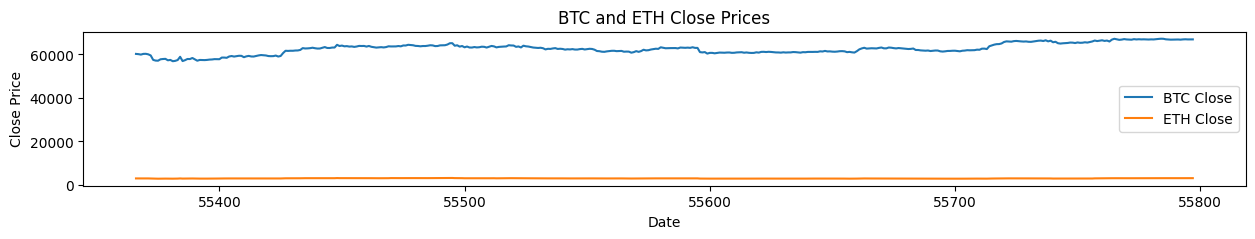

Correlation between present day's ETH closing price and next day's BTC closing price:0.9276548251947665


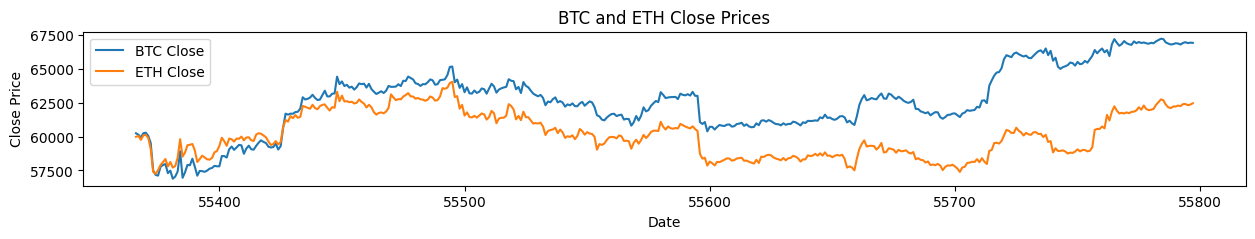

In [2]:
merged_data_short = merged_data


correlation = np.corrcoef(merged_data_short['ETH_close'], merged_data_short[f'BTC_close'])[0, 1]
# Print correlation and the first few rows of the dataset for verification
print(f"Correlation between present day's ETH closing price and next day's BTC closing price:{correlation}")
plt.figure(figsize=(15, 2))
plt.plot(merged_data_short2.index, merged_data_short2['BTC_close'], label='BTC Close')
plt.plot(merged_data_short2.index, merged_data_short2['ETH_close'], label='ETH Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC and ETH Close Prices')
plt.legend()
plt.show()
correlation = np.corrcoef(merged_data['ETH_close'], merged_data[f'BTC_close'])[0, 1]
# Print correlation and the first few rows of the dataset for verification
print(f"Correlation between present day's ETH closing price and next day's BTC closing price:{correlation}")
plt.figure(figsize=(15, 2))
plt.plot(merged_data_short2.index, merged_data_short2['BTC_close'], label='BTC Close')
plt.plot(merged_data_short2.index, merged_data_short2['ETH_close']*20, label='ETH Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC and ETH Close Prices')
plt.legend()
plt.show()

Prepare Training & Test Sets and Standardize the Data

In [3]:
load = 0

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Use only the 'BTC Price' and 'ETH Price' columns
data = merged_data_short[['BTC_close', 'ETH_close']]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Prepare sequences of the last 12 hours
sequence_length = 12
hidden_size = 5
num_layers = 5
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, 0]  # Using only BTC Price as feature
        y = data[i+seq_length, 1]    # ETH Price as target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, sequence_length)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# Define the neural network
class ETHPricePredictor(nn.Module):
    def __init__(self):
        super(ETHPricePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = x.unsqueeze(-1)  # Add feature dimension
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initialize hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initialize cell state
        out, _ = self.lstm(x, (h_0, c_0))
        out = out[:, -1, :]  # Get the last time step output
        out = self.fc(out)
        return out

model = ETHPricePredictor().to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100000

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output.squeeze(), y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
torch.save(model.state_dict(), 'model1.pkl')

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test).squeeze()
    test_loss = criterion(predictions, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Convert predictions back to original scale
predicted_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((predictions.shape[0], 1)), predictions.cpu().numpy().reshape(-1, 1)), axis=1)
)[:, 1]
actual_prices = scaler.inverse_transform(
    np.concatenate((np.zeros((y_test.shape[0], 1)), y_test.cpu().numpy().reshape(-1, 1)), axis=1)
)[:, 1]

# Print sample results
for i in range(10):
    print(f'Predicted: {predicted_prices[i]:.2f}, Actual: {actual_prices[i]:.2f}')



Epoch [10/100000], Loss: 0.0859
Epoch [20/100000], Loss: 0.0759
Epoch [30/100000], Loss: 0.0685
Epoch [40/100000], Loss: 0.0640
Epoch [50/100000], Loss: 0.0623
Epoch [60/100000], Loss: 0.0623
Epoch [70/100000], Loss: 0.0622
Epoch [80/100000], Loss: 0.0621
Epoch [90/100000], Loss: 0.0620
Epoch [100/100000], Loss: 0.0618
Epoch [110/100000], Loss: 0.0613
Epoch [120/100000], Loss: 0.0604
Epoch [130/100000], Loss: 0.0583
Epoch [140/100000], Loss: 0.0539
Epoch [150/100000], Loss: 0.0452
Epoch [160/100000], Loss: 0.0305
Epoch [170/100000], Loss: 0.0164
Epoch [180/100000], Loss: 0.0125
Epoch [190/100000], Loss: 0.0106
Epoch [200/100000], Loss: 0.0098
Epoch [210/100000], Loss: 0.0093
Epoch [220/100000], Loss: 0.0091
Epoch [230/100000], Loss: 0.0089
Epoch [240/100000], Loss: 0.0089
Epoch [250/100000], Loss: 0.0088
Epoch [260/100000], Loss: 0.0088
Epoch [270/100000], Loss: 0.0088
Epoch [280/100000], Loss: 0.0088
Epoch [290/100000], Loss: 0.0087
Epoch [300/100000], Loss: 0.0087
Epoch [310/100000],

In [5]:
rms = 0
for i in range(len(predicted_prices)):
    rms += ((predicted_prices[i]-actual_prices[i])*(predicted_prices[i]-actual_prices[i]))
rms = rms/len(predicted_prices)
print('#',hidden_size,',',num_layers,',',rms)
#layer , hidden layer size,rms
#2 , 80 , 496915.1696711829
#5 , 10 , 309543.02344859124
#10 , 5 , 338850.87313277187
#10 , 10 , 341992.9274608662
#5 , 5 , 215662.9012895165  ***
# 6 , 6 , 282112.07170788007
#3 , 5 , 271099.2154661211
# 3 , 3 , 301429.70575677836
# 4 , 4 , 327716.4057110517

# 5 , 5 , 547237.9959804995


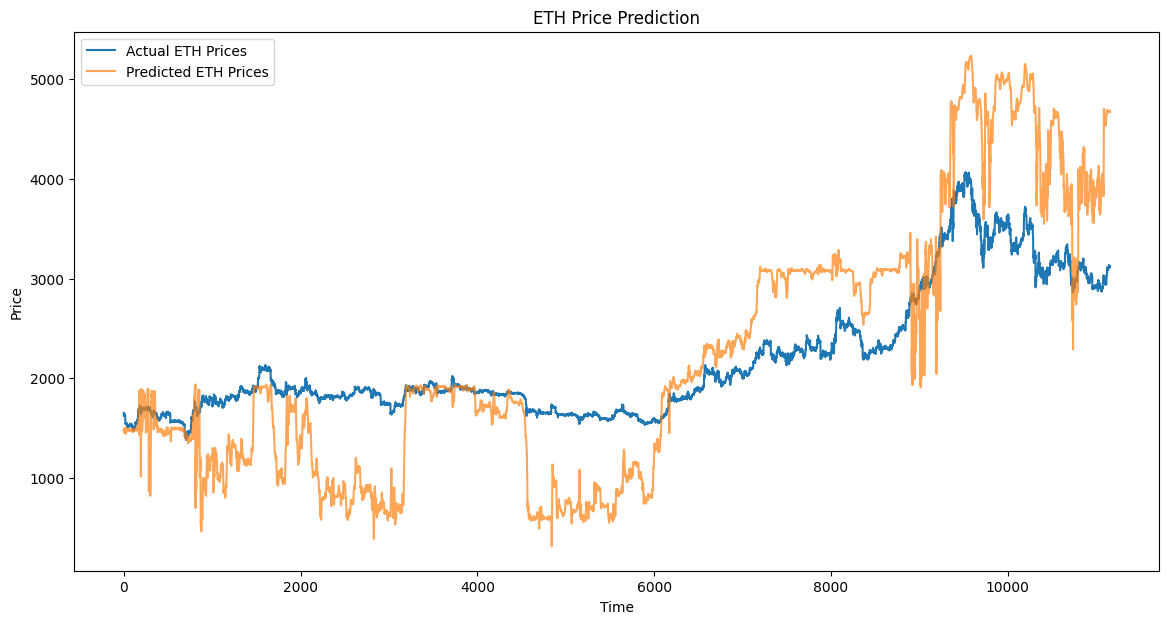

In [6]:
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual ETH Prices')
plt.plot(predicted_prices, label='Predicted ETH Prices', alpha=0.7)
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [7]:
#torch.save(model.state_dict(), model_path)
#model.load_state_dict(torch.load(model_path))

In [8]:
import matplotlib.pyplot as plt

# Move data back to CPU for plotting
X_test_cpu = X_test.cpu().numpy()
y_test_cpu = y_test.cpu().numpy()
outputs_cpu = outputs.detach().cpu().numpy()

# Inverse transform the scaled data to get the original values
y_test_inv = scaler.inverse_transform(y_test_cpu)
outputs_inv = scaler.inverse_transform(outputs_cpu)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual ETH Close Price')
plt.plot(outputs_inv, label='Predicted ETH Close Price')
plt.title('Actual vs Predicted ETH Close Price')
plt.xlabel('Time')
plt.ylabel('ETH Close Price')
plt.legend()
plt.show()


NameError: name 'outputs' is not defined

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize a list to store the predicted values
predicted_values = []

# Use the last sequence from the test set to start the prediction
current_sequence = X_test[-1].unsqueeze(0)  # Take the last sequence and unsqueeze to add batch dimension

# Number of future predictions
num_predictions = 20

# Generate predictions for the next 20 data points
for _ in range(num_predictions):
    # Move current sequence to device
    current_sequence = current_sequence.to(device)
    
    # Make predictions for the current sequence
    with torch.no_grad():
        prediction = model(current_sequence)
    
    # Append the prediction to the list of predicted values
    predicted_values.append(prediction.item())
    
    # Update the current sequence by removing the first element and adding the predicted value at the end
    current_sequence = torch.cat((current_sequence[:, 1:, :], prediction.unsqueeze(1)), dim=1)

# Convert the predicted values to numpy array
predicted_values = np.array(predicted_values)

# Inverse transform the predicted values to get the original scale
predicted_values_inv = scaler.inverse_transform(predicted_values.reshape(-1, 1))

# Print the predicted values
print("Predicted ETH Close Prices for the Next 20 Data Points:")
print(predicted_values_inv)


Predicted ETH Close Prices for the Next 20 Data Points:
[[2449.46215122]
 [1355.71568498]
 [ 762.96918687]
 [ 455.0716758 ]
 [ 299.83634489]
 [ 222.91257036]
 [ 185.14260384]
 [ 166.68344391]
 [ 157.68279435]
 [ 153.29907356]
 [ 151.16518236]
 [ 150.12679538]
 [ 149.62150846]
 [ 149.37566298]
 [ 149.25603273]
 [ 149.1978683 ]
 [ 149.16954042]
 [ 149.15576697]
 [ 149.14905774]
 [ 149.14580961]]


Train a Machine Learning Model & Evaluate the Model

Creating LSTM model

Define the LSTM Model
<br>
LSTMModel(<br>
  (lstm): LSTM(4, 50, batch_first=True)<br>
  (linear): Linear(in_features=50, out_features=7, bias=True)<br>
)

Validate the Model training

Predict Next 10 Days